In [1]:
import pandas as pd 

df = pd.read_csv('./SelfData/U08_ONU16_15S_AiGi-1_635745_195000.csv')
#df.head()

df['Gi-1'] = df['Gi-1'] / 195000 #手動正規化
df['Ai'] = df['Ai'] / 635745 #手動正規化

print(df[40:50])

# 将dataframe 转化为 array
data = df.values

          Ai      Gi-1
40  0.000000  0.029374
41  0.000406  0.000000
42  0.022586  0.001451
43  0.041598  0.080856
44  0.015811  0.141236
45  0.024585  0.045600
46  0.005793  0.084482
47  0.002633  0.016010
48  0.020478  0.009626
49  0.039665  0.074446


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import datetime
import math
import itertools
from sklearn import preprocessing
import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt

C:\Users\joker\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  after removing the cwd from sys.path.


In [3]:
# 1 : 数据切分
result = []
time_steps = 11

for i in range(len(data)-time_steps):
    result.append(data[i:i+time_steps])

result = np.array(result)

In [4]:
# 训练集和测试集的数据量划分
train_size = int(0.8*len(result))

# 训练集切分
train = result[:train_size,:]

x_train = train[:, :-1]
y_train = train[:, -1][:,-1]
   
x_test = result[train_size:,:-1]
y_test = result[train_size:,-1][:,-1]

feature_nums = len(df.columns)

# 数据重塑
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1],x_train.shape[2])
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1],x_test.shape[2])

print("X_train", x_train.shape)
print("y_train", y_train.shape)
print("X_test", x_test.shape)
print("y_test", y_test.shape)

X_train (36889, 10, 2)
y_train (36889,)
X_test (9223, 10, 2)
y_test (9223,)


In [5]:
from __future__ import print_function
import math
#importing keras modules
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation ,Dropout , Flatten , Conv1D , MaxPooling1D, Input, Reshape, concatenate
from tensorflow.keras.layers import LSTM
from tensorflow.keras import losses
from tensorflow.keras import optimizers

#def build_model(input):
#    model = Sequential()
#    model.add(Dense(128,input_shape=(input[0],input[1])))
#    model.add(Conv1D(filters=80,kernel_size=1,padding='same',activation='relu',kernel_initializer="glorot_uniform"))
#    model.add(MaxPooling1D(pool_size=2,padding='valid'))
#    model.add(Conv1D(filters=48,kernel_size=1,padding='same',activation='relu',kernel_initializer="glorot_uniform"))
#    model.add(MaxPooling1D(pool_size=2, padding='valid'))
#    model.add(LSTM(32,return_sequences=True))
#    model.add(LSTM(16,return_sequences=False))
#    model.add(Dense(32, activation="relu", kernel_initializer="uniform"))
#    model.add(Dense(1, activation="relu", kernel_initializer="uniform"))
#    model.compile(loss='mse',optimizer='adam',metrics=['mae'])
#    return model
timesteps_ = time_steps - 1
#look_back = timesteps_
#inputsR = Input(shape=(timesteps,))
#inputs_A = Input(shape=(look_back,))
#inputs_G = Input(shape=(look_back,))
#inputs = LayerNormalization(axis=1)(inputs)
#inputs_R_test = Reshape((inputs_R.shape[1],1))(inputs_R)
#inputs_A_test = Reshape((inputs_A.shape[1], 1))(inputs_A)
#inputs_G_test = Reshape((inputs_G.shape[1], 1))(inputs_G)

#input_merge = concatenate([inputs_A_test,inputs_G_test], axis = -1)

#tgt1 = Reshape((look_back, 2))(input_merge)
inputs = Input(shape=(timesteps_, 2))
tgt1 = tf.keras.layers.Reshape((timesteps_, 2), input_shape=(timesteps_, ))(inputs)

tgt1 = Dense(units=128, input_shape=(timesteps_, 2))(tgt1)
#1st CNN Layer
tgt2 = Conv1D(filters=80,kernel_size=1,padding='same',activation='relu',kernel_initializer="glorot_uniform")(tgt1)
tgt3 = MaxPooling1D(pool_size=2,padding='valid')(tgt2)
#2nd CNN Layer
tgt4 = Conv1D(filters=48,kernel_size=1,padding='same',activation='relu',kernel_initializer="glorot_uniform")(tgt3)
tgt5 = MaxPooling1D(pool_size=2, padding='valid')(tgt4)
#1st LSTM Layer
tgt6 = LSTM(32,return_sequences=True)(tgt5) #32
#tgt6_2 = LSTM(30,return_sequences=True)(tgt6) #32
#tgt6_3 = LSTM(22,return_sequences=True)(tgt6_2) #32
tgt7 = LSTM(16,return_sequences=False)(tgt6) #16
#Dense
tgt8 = Dense(32, activation="relu", kernel_initializer="uniform")(tgt7)
predictions = Dense(1, activation="relu", kernel_initializer="uniform")(tgt8)

#model = Model(inputs=inputs, outputs=predictions)
model = Model(inputs=inputs, outputs=predictions)
model.compile(loss='mse',optimizer='Adam',metrics=['mae'])

In [6]:
#model = build_model([9,1,1]) #[x_train shape的第二個數字, x_train shape的第三個數字, 1]
#Summary of the Model
print(model.summary())

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10, 2)]           0         
_________________________________________________________________
reshape (Reshape)            (None, 10, 2)             0         
_________________________________________________________________
dense (Dense)                (None, 10, 128)           384       
_________________________________________________________________
conv1d (Conv1D)              (None, 10, 80)            10320     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 5, 80)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 5, 48)             3888      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 2, 48)            

In [7]:
from timeit import default_timer as timer
start = timer()
history = model.fit(x_train,
                    y_train,
                    batch_size=128,
                    epochs=100,
                    validation_split=0.2,
                    verbose=2)
end = timer()
print(end - start)

Epoch 1/100
231/231 - 2s - loss: 0.0110 - mae: 0.0578 - val_loss: 0.0150 - val_mae: 0.0646
Epoch 2/100
231/231 - 1s - loss: 0.0101 - mae: 0.0554 - val_loss: 0.0134 - val_mae: 0.0591
Epoch 3/100
231/231 - 1s - loss: 0.0098 - mae: 0.0541 - val_loss: 0.0141 - val_mae: 0.0613
Epoch 4/100
231/231 - 1s - loss: 0.0097 - mae: 0.0536 - val_loss: 0.0137 - val_mae: 0.0562
Epoch 5/100
231/231 - 1s - loss: 0.0094 - mae: 0.0525 - val_loss: 0.0121 - val_mae: 0.0580
Epoch 6/100
231/231 - 1s - loss: 0.0093 - mae: 0.0522 - val_loss: 0.0108 - val_mae: 0.0537
Epoch 7/100
231/231 - 1s - loss: 0.0092 - mae: 0.0520 - val_loss: 0.0102 - val_mae: 0.0536
Epoch 8/100
231/231 - 1s - loss: 0.0092 - mae: 0.0516 - val_loss: 0.0103 - val_mae: 0.0567
Epoch 9/100
231/231 - 1s - loss: 0.0091 - mae: 0.0518 - val_loss: 0.0113 - val_mae: 0.0527
Epoch 10/100
231/231 - 1s - loss: 0.0092 - mae: 0.0517 - val_loss: 0.0102 - val_mae: 0.0519
Epoch 11/100
231/231 - 1s - loss: 0.0091 - mae: 0.0514 - val_loss: 0.0100 - val_mae: 0.05

Epoch 91/100
231/231 - 1s - loss: 0.0086 - mae: 0.0504 - val_loss: 0.0104 - val_mae: 0.0535
Epoch 92/100
231/231 - 1s - loss: 0.0086 - mae: 0.0504 - val_loss: 0.0097 - val_mae: 0.0516
Epoch 93/100
231/231 - 1s - loss: 0.0086 - mae: 0.0505 - val_loss: 0.0100 - val_mae: 0.0510
Epoch 94/100
231/231 - 1s - loss: 0.0086 - mae: 0.0504 - val_loss: 0.0111 - val_mae: 0.0530
Epoch 95/100
231/231 - 1s - loss: 0.0086 - mae: 0.0503 - val_loss: 0.0117 - val_mae: 0.0558
Epoch 96/100
231/231 - 1s - loss: 0.0086 - mae: 0.0504 - val_loss: 0.0119 - val_mae: 0.0543
Epoch 97/100
231/231 - 1s - loss: 0.0086 - mae: 0.0504 - val_loss: 0.0114 - val_mae: 0.0532
Epoch 98/100
231/231 - 1s - loss: 0.0085 - mae: 0.0500 - val_loss: 0.0102 - val_mae: 0.0534
Epoch 99/100
231/231 - 1s - loss: 0.0086 - mae: 0.0502 - val_loss: 0.0109 - val_mae: 0.0536
Epoch 100/100
231/231 - 1s - loss: 0.0085 - mae: 0.0502 - val_loss: 0.0110 - val_mae: 0.0526
102.61222090000001


In [8]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])

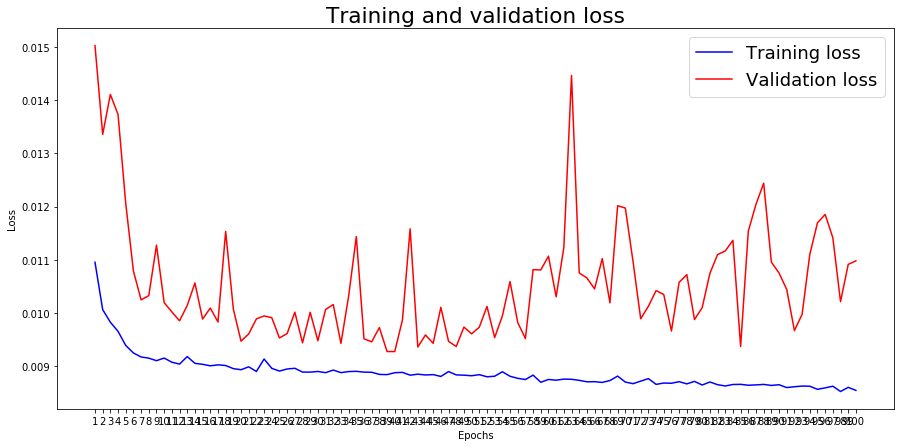

In [9]:
# 画出训练集和验证集的损失曲线

import matplotlib.pyplot as plt

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
loss_values50 = loss_values[0:150]
val_loss_values50 = val_loss_values[0:150]
epochs = range(1, len(loss_values50) + 1)
plt.plot(epochs, loss_values50, 'b',color = 'blue', label='Training loss')
plt.plot(epochs, val_loss_values50, 'b',color='red', label='Validation loss')
plt.rc('font', size = 18)
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.xticks(epochs)
fig = plt.gcf()
fig.set_size_inches(15,7)
#fig.savefig('img/tcstest&validationlosscnn.png', dpi=300)
plt.show()

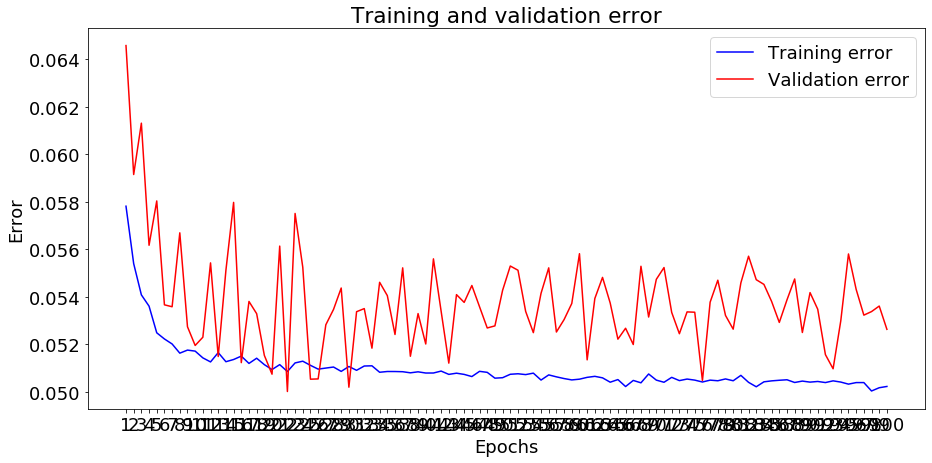

In [10]:
# 画出训练集和验证集的误差图像

#mae = history_dict['mean_absolute_error']
#vmae = history_dict['val_mean_absolute_error']
mae = history.history['mae']
vmae = history.history['val_mae']
epochs = range(1, len(mae) + 1)
plt.plot(epochs, mae, 'b',color = 'blue', label='Training error')
plt.plot(epochs, vmae, 'b',color='red', label='Validation error')
plt.title('Training and validation error')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.legend()
plt.xticks(epochs)
fig = plt.gcf()
fig.set_size_inches(15,7)
#fig.savefig('img/tcstest&validationerrorcnn.png', dpi=300)
plt.show()

In [11]:
model.metrics_names

['loss', 'mae']

In [12]:
trainScore = model.evaluate(x_train, y_train, verbose=0)
testScore = model.evaluate(x_test, y_test, verbose=0)

In [13]:
#predicting values for y_test
p = model.predict(x_test)

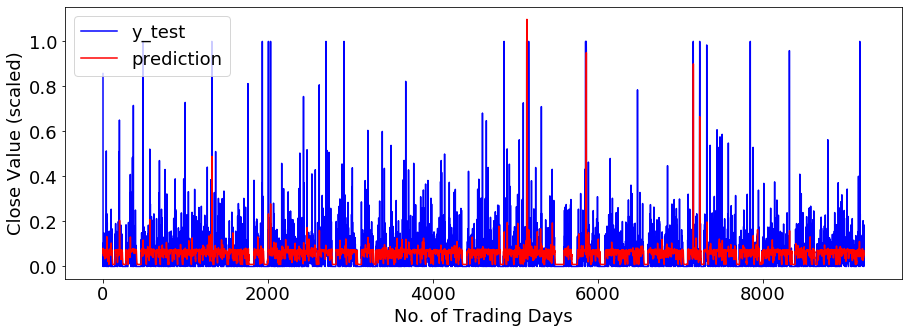

In [14]:
plt.plot(y_test,color='blue', label='y_test')
plt.plot(p,color='red', label='prediction')
plt.xlabel('No. of Trading Days')
plt.ylabel('Close Value (scaled)')
plt.legend(loc='upper left')
fig = plt.gcf()
fig.set_size_inches(15, 5)
#fig.savefig('img/tcstestcnn.png', dpi=300)
plt.show()

In [15]:
p1= model.predict(x_train)

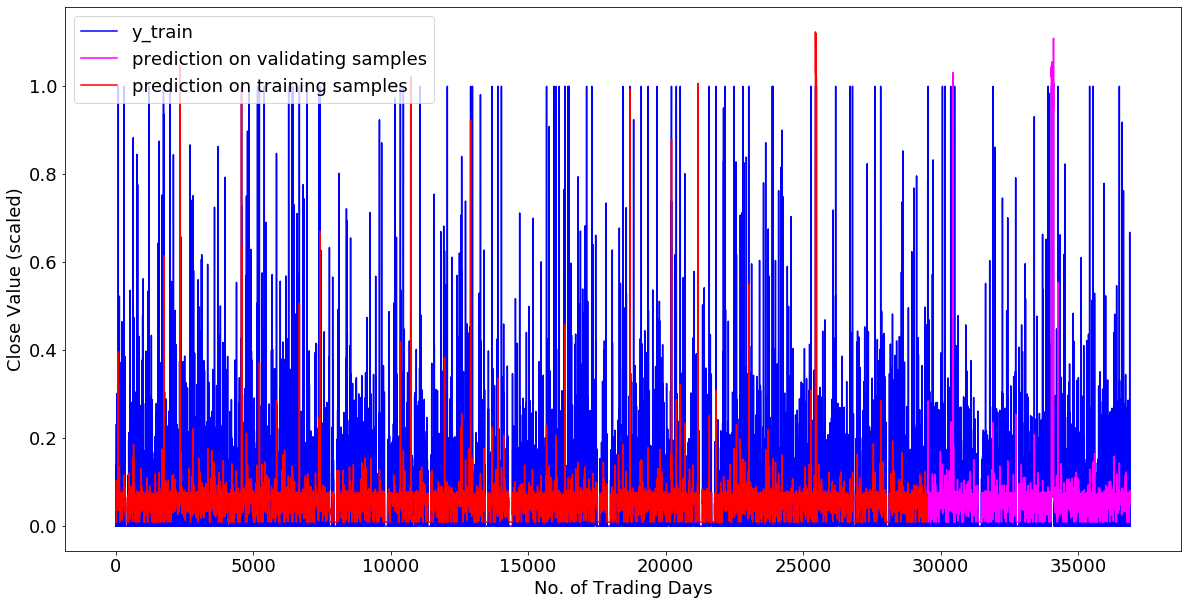

In [16]:
plt.plot(y_train,color='blue', label='y_train')
x = np.array(range(29511,36889)) #range(x_train shape第一個數字的0.8倍, x_train shape第一個數字)
plt.plot(x,p1[29511:],color = 'magenta',label ='prediction on validating samples') #p1[數字:] 數字代表x_train shape第一個數字的0.8倍
plt.plot(p1[:29511],color='red', label='prediction on training samples')
#x = np.array(range(29512,36890)) #range(x_train shape第一個數字的0.8倍, x_train shape第一個數字)
#plt.plot(x,p1[29512:],color = 'magenta',label ='prediction on validating samples')
#plt.plot(y_train,color='blue', label='y_train')
plt.xlabel('No. of Trading Days')
plt.ylabel('Close Value (scaled)')
plt.legend(loc='upper left')
fig = plt.gcf()
fig.set_size_inches(20,10)
#fig.savefig('img/tcstraincnn.png', dpi=300)
plt.show()

In [17]:
#手動正規化
y = y_test * 635745   # 原始数据经过除以10000进行缩放，因此乘以10000,返回到原始数据规模
y_pred = p.reshape(9223)  # 测试集数据大小为265
y_pred = y_pred * 635745   # 原始数据经过除以10000进行缩放，因此乘以10000,返回到原始数据规模

In [18]:
from sklearn.metrics import mean_absolute_error

In [19]:
print('Trainscore RMSE \tTrain Mean abs Error \tTestscore Rmse \t Test Mean abs Error')
print('%.9f \t\t %.9f \t\t %.9f \t\t %.9f' % (math.sqrt(trainScore[0]),trainScore[1],math.sqrt(testScore[0]),testScore[1]))

Trainscore RMSE 	Train Mean abs Error 	Testscore Rmse 	 Test Mean abs Error
0.094816318 		 0.049724363 		 0.090634931 		 0.049217142


In [20]:
print('mean absolute error \t mean absolute percentage error')
print(' %.9f \t\t\t %.9f' % (mean_absolute_error(y,y_pred),(np.mean(np.abs((y - y_pred) / y)) * 100)))

mean absolute error 	 mean absolute percentage error
 31289.553083693 			 inf


C:\Users\joker\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


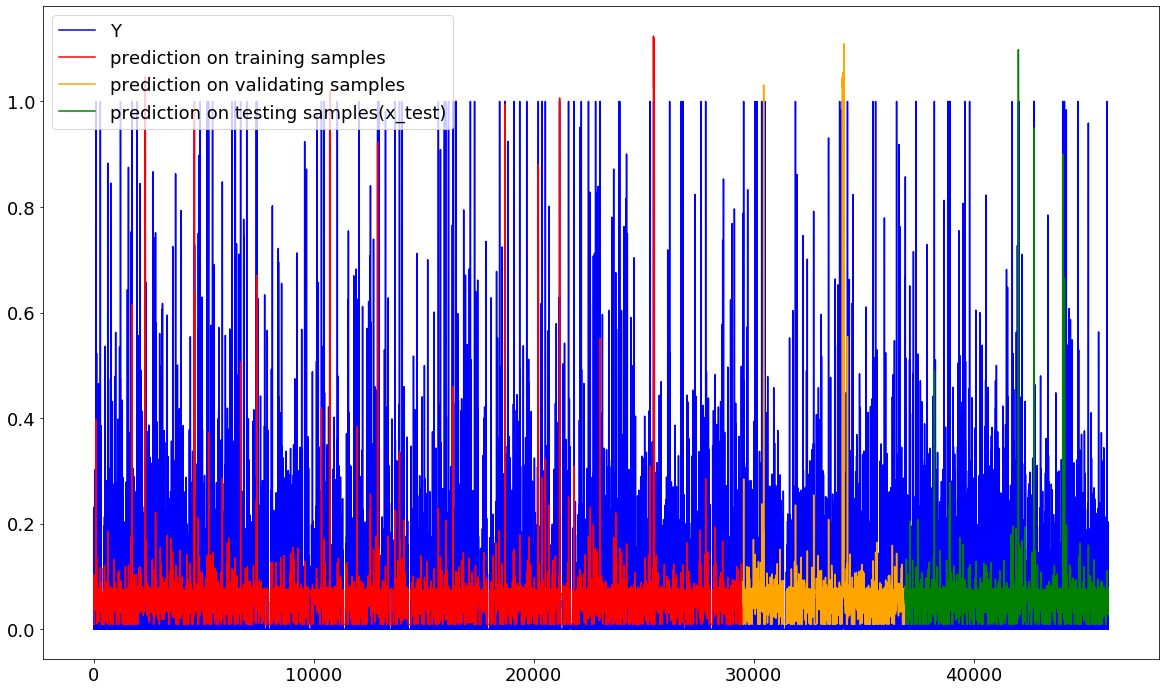

In [21]:
Y = np.concatenate((y_train,y_test),axis = 0)
plt.plot(Y,color='blue', label='Y')
P = np.concatenate((p1,p),axis = 0)
#plotting the complete Y set with predicted values on x_train and x_test(variable p1 & p respectively given above)
#for 
plt.plot(P[:29511],color='red', label='prediction on training samples') #p[:數字] 數字代表x_train shape第一個數字的0.8倍
#for validating samples
z = np.array(range(29511,36889)) #range(x_train shape第一個數字的0.8倍, x_train shape第一個數字)
plt.plot(z,P[29511:36889],color = 'orange',label ='prediction on validating samples') #P[x_train shape第一個數字的0.8倍:x_train shape第一個數字]
#for testing samples
x = np.array(range(36889,46112)) #range(x_train shape第一個數字, x_train shape第一個數字 + x_test shape第一個數字)
plt.plot(x,P[36889:],color = 'green',label ='prediction on testing samples(x_test)') #p[數字:] 數字代表x_train shape第一個數字

#plt.plot(Y,color='blue', label='Y')
plt.legend(loc='upper left')
fig = plt.gcf()
fig.set_size_inches(20,12)
plt.show()

In [ ]:
#model.save('0522_U08D00_ONU16_onuAi_635745_4layer_timesteps10.h5', include_optimizer=False)